In [1]:
import torch
torch.cuda.get_device_name(0)

'Tesla T4'

In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
#librería agregada por error que salia
import scipy.spatial 
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
%matplotlib inline

In [5]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [6]:
#set the root to the Shanghai dataset you download
root = '/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/'

In [7]:
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_train,part_A_test]

In [8]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

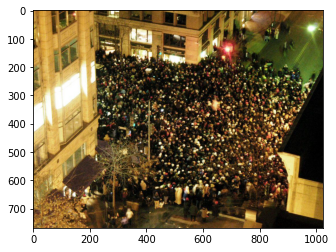

In [9]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[50]))

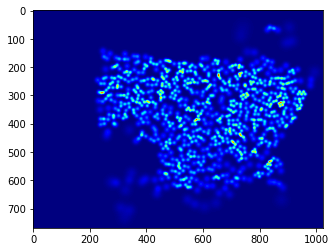

In [10]:
gt_file = h5py.File(img_paths[50].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [11]:
np.sum(groundtruth)

775.96985

In [12]:
path_sets = [part_B_train,part_B_test]
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)     
# creating density map for part_b images

for img_path in img_paths:
    print (img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/part_B_final/train_data/images/IMG_10.jpg


KeyboardInterrupt: ignored

In [13]:
!python --version

Python 3.6.9


Entrenamos el modelo

In [14]:
%cd /content
!python train.py part_A_train.json part_A_val.json 0 0

/content
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
  7% 34.3M/528M [00:03<00:44, 11.7MB/s]
Traceback (most recent call last):
  File "train.py", line 230, in <module>
    main()        
  File "train.py", line 65, in main
    model = CSRNet()
  File "/content/model.py", line 21, in __init__
    mod = models.vgg16(pretrained = True)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/models/vgg.py", line 150, in vgg16
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/models/vgg.py", line 93, in _vgg
    progress=progress)
  File "/usr/local/lib/python3.6/dist-packages/torch/hub.py", line 555, in load_state_dict_from_url
    download_url_to_file(url, cached_file, hash_prefix, progress=progress)
  File "/usr/local/lib/python3.6/dist-packages/torch/hub.py", line 447, in download_url_to_file
    buffer = u.read(8192)
  File

In [15]:
#importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
%matplotlib inline

In [16]:
from torchvision import datasets, transforms
transform=transforms.Compose([
                      transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]),
                  ])

In [17]:
#defining the location of dataset
root = '/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/'
part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = os.path.join(root,'part_A_final/test_data','images')
part_B_train = os.path.join(root,'part_B_final/train_data','images')
part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test]

In [18]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [19]:
model = CSRNet()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [20]:
#defining the model
model = model.cuda()

In [21]:
checkpoint = torch.load('0model_best.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

Revisamos el MAE (Mean Absolute Error) en imagenes de pruebas para evaluar nuestro modelo

In [22]:
mae = 0
for i in tqdm(range(len(img_paths))):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.jpg','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = model(img.unsqueeze(0))
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth))
print (mae/len(img_paths))

100%|██████████| 182/182 [03:02<00:00,  1.00s/it]

75.69090073973268


Validamos la predicción con una imagen cualquiera

Predicted Count :  384


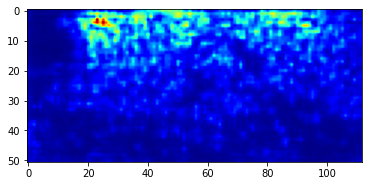

Original Count :  384


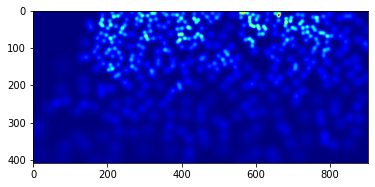

Original Image


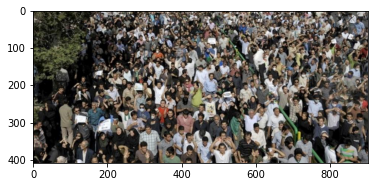

In [ ]:
from matplotlib import cm as c
img = transform(Image.open('/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/part_A_final/test_data/images/IMG_100.jpg').convert('RGB')).cuda()

output = model(img.unsqueeze(0))
print("Predicted Count : ",int(output.detach().cpu().sum().numpy()))
temp = np.asarray(output.detach().cpu().reshape(output.detach().cpu().shape[2],output.detach().cpu().shape[3]))
plt.imshow(temp,cmap = c.jet)
plt.show()
temp = h5py.File('/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/part_A_final/test_data/ground_truth/IMG_100.h5', 'r')
temp_1 = np.asarray(temp['density'])
plt.imshow(temp_1,cmap = c.jet)
print("Original Count : ",int(np.sum(temp_1)) + 1)
plt.show()
print("Original Image")
plt.imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/TFAI/Shanghai/part_A_final/test_data/images/IMG_100.jpg'))
plt.show()